# Time-warped PCA demo

This notebook demonstrates the application of time-warped PCA to a synthetic dataset to recover the underlying latent dynamics and trial alignment. The dataset consists of a one dimensional latent state with three events that occur over the course of each trial. The exact time of each event is jittered from trial-to-trial which makes averaging across trials distort the underlying dynamics.

## Setup

In [1]:
import sys
sys.path.append('/Users/colinhoy/Code/Apps/twpca')

In [2]:
%pylab inline
np.random.seed(1234)
from scipy.ndimage.filters import convolve1d, gaussian_filter1d
from twpca import TWPCA
from twpca.regularizers import curvature
import itertools as itr
import seaborn as sns
sns.set_style("ticks")
%load_ext autoreload
%autoreload 2

//anaconda/lib/python2.7/site-packages/h5py/__init__.py:13: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from h5py import _conv
//anaconda/lib/python2.7/site-packages/h5py/__init__.py:16: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from h5py import h5a, h5d, h5ds, h5f, h5fd, h5g, h5r, h5s, h5t, h5p, h5z
//anaconda/lib/python2.7/site-packages/h5py/_hl/group.py:15: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from h5py import h5g, h5i, h5o, h5r, h5t, h5l, h5p
//anaconda/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from .linbin import fast_linbin
//anaconda/lib/python2.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:11: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from ._smoothers_lowess import lowess as _lowess
:0: FutureWarning: IPython

Populating the interactive namespace from numpy and matplotlib


In [3]:
import h5py
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm

%matplotlib inline

//anaconda/lib/python2.7/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:33: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from . import kalman_loglike


## Load Dataset

#### HFA

In [4]:
SBJ = 'IR32'
SBJ_dir = '/Volumes/hoycw_clust/PRJ_Stroop/data/'+SBJ
proc_dir = SBJ_dir+'/04_proc/'
# f = h5py.File(proc_dir+SBJ+'_CNI_design_mtx.mat', 'r')
# for k, v in f.items():
#     design = np.array(v)
    
f2 = h5py.File(proc_dir+SBJ+'_HFA_ROI_HGm_S_zbtS_trl2to251_sm0_wn100_stat0.mat','r')
for k, v in f2.items():
    print(k)
    print(v)

data = np.squeeze(np.array(v['powspctrm']))
# Convert to (trials, time, electrodes)
data = np.swapaxes(np.swapaxes(data, 2, 0), 1, 2)

time = np.squeeze(np.array(v['time']))
srate = 1000 # assuming this

# Trick for labels is to grab the reference (ref) and then pull that out of f2
labels = [''.join(map(chr, f2[ref])) for ref in f2['hfa']['label'][0]]

print data.shape
f2.close()

#refs#
<HDF5 group "/#refs#" (3148 members)>
hfa
<HDF5 group "/hfa" (8 members)>
(242, 2761, 106)


In [5]:
#f['trial_info'].keys()

#### Trial Info

In [6]:
ti_fname = SBJ_dir+'/03_events/'+SBJ+'_trial_info_final.mat'
f = h5py.File(ti_fname, 'r')
trl_info = {}
for name in f['trial_info'].keys():
    #print name, f['trial_info'][name].shape
    if isinstance(f['trial_info'][name], h5py.Group):
        trl_info[name] = {}
        for name2 in f['trial_info'][name].keys():
            trl_info[name][name2] = f['trial_info'][name][name2][:]
    else:
        trl_info[name] = f['trial_info'][name][:]
# trial_info = pd.DataFrame(trial_info_mat,columns=('block_n','trial_n',
#                                                   'response_time','marker_time','onset_time',
#                                                  'word_onset','resp_onset','condition_n',
#                                                  'error'), index=[1])
f.close()

sorted_rt_idx = np.argsort(trl_info['response_time'])

#### View the data

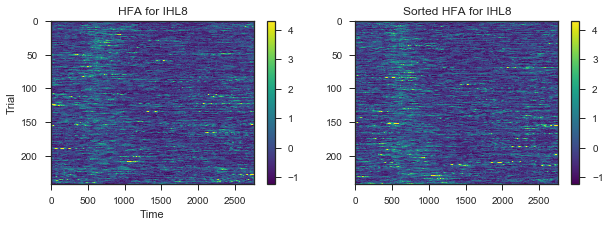

In [7]:
elec_ix = 61
color_perc = .5
figure(figsize=(10,3))
subplot(121)
imshow(data[..., elec_ix], aspect='auto', cmap=cm.viridis,
       clim=(min(data[..., elec_ix].ravel()), max(data[..., elec_ix].ravel())*color_perc))
colorbar()
title('HFA for '+labels[elec_ix])
xlabel('Time')
ylabel('Trial')
subplot(122)
imshow(np.squeeze(data[sorted_rt_idx, :, elec_ix]), aspect='auto', cmap=cm.viridis,
      clim=(min(data[sorted_rt_idx, :, elec_ix].ravel()),
            max(data[sorted_rt_idx, :, elec_ix].ravel())*color_perc))
colorbar()
title('Sorted HFA for '+labels[elec_ix])

#### Trim data to epochs of interest

In [8]:
# trim to min/max before stim and after resp
epoch_lim = [-0.05, 1]
min_idx = np.where(time<=epoch_lim[0])[0][-1]+1
try:
    max_idx = np.where(time>=trl_info['response_time'].max()+epoch_lim[1])[0][1]
except IndexError:
    max_idx = -1
print 'Time range for analysis: ', time[min_idx], time[max_idx]
data = data[:,min_idx:max_idx,:]
time = time[min_idx:max_idx]

Time range for analysis:  -0.04999999999999887 2.2579999999999494


In [21]:
# replace data past epoch_lim with NaNs
for t_ix in range(data.shape[0]):
    # Find last piece of good data, one index past that make NaNs
    epoch_end = np.where(time>=trl_info['response_time'][0][t_ix]+epoch_lim[1])[0]
#     print t_ix, trl_info['response_time'][0][t_ix], epoch_end, time[epoch_end]
    try:
        data[t_ix,epoch_end[0]+1:,:] = NaN
    except IndexError:
        pass

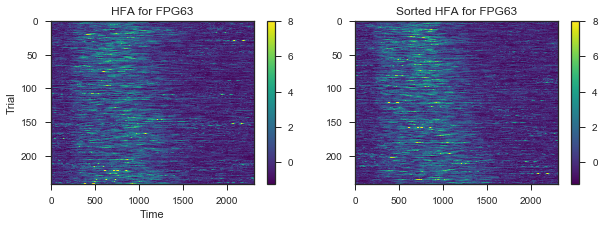

In [9]:
elec_ix = 52
figure(figsize=(10,3))
subplot(121)
imshow(data[..., elec_ix], aspect='auto', cmap=cm.viridis,
       clim=(min(data[..., elec_ix].ravel()), max(data[..., elec_ix].ravel())*color_perc))
colorbar()
title('HFA for '+labels[elec_ix])
xlabel('Time')
ylabel('Trial')
subplot(122)
imshow(np.squeeze(data[sorted_rt_idx, :, elec_ix]), aspect='auto', cmap=cm.viridis,
      clim=(min(data[sorted_rt_idx, :, elec_ix].ravel()),
            max(data[sorted_rt_idx, :, elec_ix].ravel())*color_perc))
colorbar()
title('Sorted HFA for '+labels[elec_ix])

## twPCA options

In [10]:
n_components = 4
smooth_std = 1.0

warp_penalty_strength = 0.01
time_penalty_strength = 1.0

n_trial, n_time, n_neuron = data.shape
stim_onset = np.where(time==0)[0][0]

## Construct and fit twPCA model

In [11]:
# Add an L1 penalty on the second order finite difference of the warping functions
# This encourages the warping functions to be piecewise linear.
warp_regularizer = curvature(scale=warp_penalty_strength, power=1)
# Adds an L2 penatly on the second order finite difference of the temporal factors.
# Encourages the temporal factors to be smooth in time.
time_regularizer = curvature(scale=time_penalty_strength, power=2, axis=0)

model = TWPCA(data,
              n_components,
              origin_idx=stim_onset,
              warp_regularizer=warp_regularizer,
              time_regularizer=time_regularizer,
              fit_trial_factors=False,
              warpinit='linear')

# Fit model with gradient descent, starting with a learning rate of 1e-1 for 250 iterations,
# and then a learning rate of 1e-2 for 500 iterations
model.fit(lr=(1e-1, 1e-2), niter=(250, 500))
# Extract model parameters and reconstruction of the data (X_pred)
params = model.params
X_pred = model.predict()

100%|██████████| 500/500 [13:08<00:00,  1.58s/it]


### Visualize learned warping functions

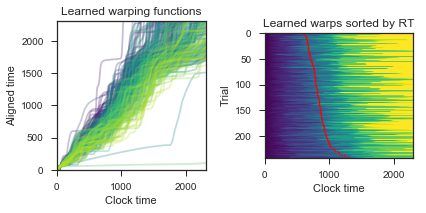

In [12]:
colors = [cm.viridis(i) for i in np.linspace(0, 0.9, n_trial)]

subplot(121)
for t in range(n_trial):
    plot(params['warp'][sorted_rt_idx[0][t],:].T, alpha=0.3, color=colors[t]);
axis('square')
xlabel('Clock time')
ylabel('Aligned time')
xlim(0, n_time);
ylim(0, n_time)
title('Learned warping functions')
subplot(122)
imshow(params['warp'][sorted_rt_idx[0],:], cmap=cm.viridis, aspect = 8)
scatter(trl_info['response_time'][0,sorted_rt_idx[0]]*srate+stim_onset,range(n_trial),
        s=1,c='r')
xlabel('Clock time')
ylabel('Trial')
ylim(n_trial, 0)
title('Learned warps sorted by RT')
plt.tight_layout()

# twPCA accurately recovers latent dynamics

In [13]:
# data ~= np.dot(u, np.dot(s,v))
u,s,v = np.linalg.svd(np.nanmean(data, axis=0), full_matrices=False)
print u.shape, s.shape, v.shape
# Below: outer product of first PC and its weights, scaled by sqrt(eigenvalues)
#   this is a full reconstruction of the first PC in the original space
pca_trial_recon = s[0]*np.outer(u[:,0], v[0])
# to view it: imshow(s[0]*np.outer(u[:,0], v[0]),aspect=0.01,cmap=cm.viridis);colorbar()

(2308, 106) (106,) (106, 106)


In [14]:
avg_trial = np.nanmean(np.nanmean(data,0),1)

pca_time_factor = np.zeros([n_time,n_components])
for pc_ix in range(n_components):
    stmp = np.sign(np.sum(u[:,pc_ix]))  # is PC + or -
    # normalization step
    stmp *= np.linalg.norm(avg_trial)/np.linalg.norm(u[:,pc_ix])
    pca_time_factor[:,pc_ix] = stmp*u[:,pc_ix]

//anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


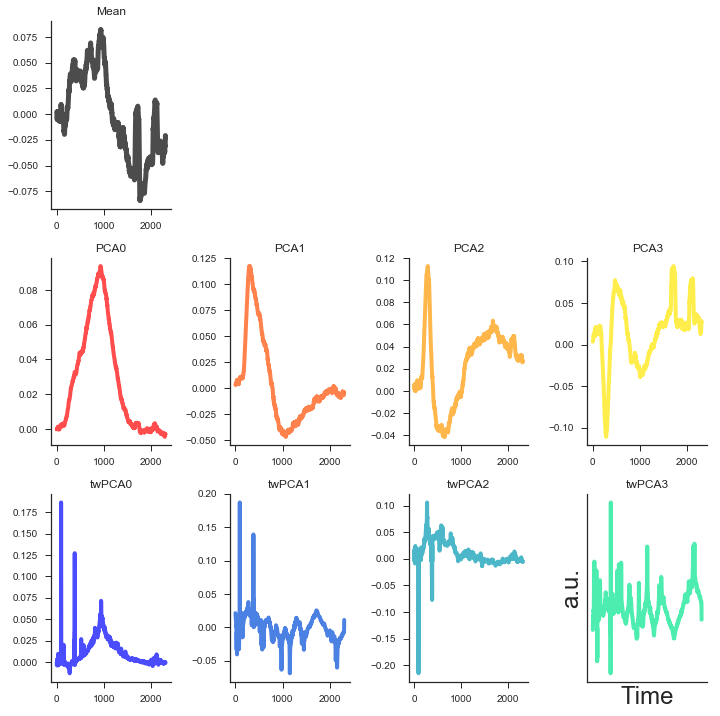

In [15]:
pca_colors = [cm.autumn(i) for i in np.linspace(0, 0.9, n_components)]
twpca_colors = [cm.winter(i) for i in np.linspace(0, 0.9, n_components)]

time_fctr = params['time']
s2 = np.sign(np.sum(time_fctr))
# normalization step
s2 *= np.linalg.norm(avg_trial.ravel())/np.linalg.norm(time_fctr.ravel())

figure(figsize=(10,10))
subplot(3,n_components,1)
plot(avg_trial, '-k', lw=5, alpha=0.7, label='Mean')
title('Mean')

for pc_ix in range(n_components):
    subplot(3,n_components,n_components+pc_ix+1)
    plot(pca_time_factor[:,pc_ix], lw=4, alpha=0.7, c=pca_colors[pc_ix])#label='PCA'+str(pc_ix), 
    title('PCA'+str(pc_ix))
for pc_ix in range(n_components):
    subplot(3,n_components,2*n_components+pc_ix+1)
    plot(s2*time_fctr[:,pc_ix], alpha=0.7, lw=4, c=twpca_colors[pc_ix])#label='twPCA'+str(pc_ix), 
    title('twPCA'+str(pc_ix))
    #ax.set_title('warp={0:.2f}, time={1:.2f}'.format(warp_reg, time_reg))

plt.tight_layout()
legend(loc='upper right',fontsize=24, bbox_to_anchor=(1.2, 0.8))#, fontsize=24)
xticks([])
yticks([])
xlabel('Time', fontsize=24)
ylabel('a.u.', fontsize=24)
sns.despine()
# xlim(10, 110)

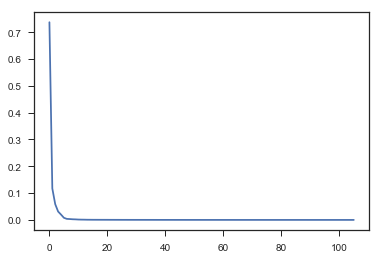

In [16]:
# Percent variance explained = Si^2 / sum(Sj^2)
pca_var_exp = [np.power(i,2)/sum(np.power(s,2)) for i in s]
# twpca_var_exp = 
plot(pca_var_exp)

# twPCA reconstruction of the data

In [17]:
# you can use the model object to align data
#  (compare this to the aligned_data from above)
est_aligned_data = model.transform()

//anaconda/lib/python2.7/site-packages/scipy/interpolate/interpolate.py:571: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
//anaconda/lib/python2.7/site-packages/scipy/interpolate/interpolate.py:574: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


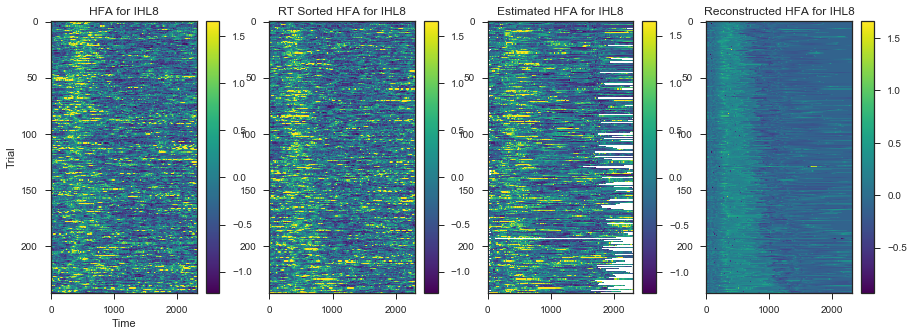

In [19]:
elec_ix = 61
color_perc = .2
color_perc2 = 1
figure(figsize=(15,5))
subplot(141)
imshow(data[..., elec_ix], aspect='auto', cmap=cm.viridis,
       clim=(min(data[..., elec_ix].ravel()), max(data[..., elec_ix].ravel())*color_perc))
colorbar()
title('HFA for '+labels[elec_ix])
xlabel('Time')
ylabel('Trial')
subplot(142)
imshow(np.squeeze(data[sorted_rt_idx, :, elec_ix]), aspect='auto', cmap=cm.viridis,
      clim=(min(data[sorted_rt_idx, :, elec_ix].ravel()),
            max(data[sorted_rt_idx, :, elec_ix].ravel())*color_perc))
colorbar()
title('RT Sorted HFA for '+labels[elec_ix])
subplot(143)
imshow(np.squeeze(est_aligned_data[sorted_rt_idx, :, elec_ix]), aspect='auto', cmap=cm.viridis,
      clim=(nanmin(est_aligned_data[sorted_rt_idx, :, elec_ix].ravel()),
            nanmax(est_aligned_data[sorted_rt_idx, :, elec_ix].ravel())*color_perc))
colorbar()
title('Estimated HFA for '+labels[elec_ix])
subplot(144)
imshow(np.squeeze(X_pred[sorted_rt_idx, :, elec_ix]), aspect='auto', cmap=cm.viridis,
      clim=(nanmin(X_pred[sorted_rt_idx, :, elec_ix].ravel()),
            nanmax(X_pred[sorted_rt_idx, :, elec_ix].ravel())*color_perc2))
colorbar()
title('Reconstructed HFA for '+labels[elec_ix])

In [41]:
for a,b in enumerate(labels):
    print a,b

0 FPG1
1 FPG2
2 FPG3
3 FPG4
4 FPG5
5 FPG6
6 FPG8
7 FPG9
8 FPG10
9 FPG11
10 FPG12
11 FPG13
12 FPG14
13 FPG15
14 FPG16
15 FPG17
16 FPG18
17 FPG19
18 FPG20
19 FPG21
20 FPG22
21 FPG23
22 FPG24
23 FPG26
24 FPG30
25 FPG31
26 FPG32
27 FPG33
28 FPG38
29 FPG39
30 FPG41
31 FPG42
32 FPG43
33 FPG44
34 FPG45
35 FPG46
36 FPG47
37 FPG48
38 FPG49
39 FPG50
40 FPG51
41 FPG52
42 FPG53
43 FPG54
44 FPG55
45 FPG56
46 FPG57
47 FPG58
48 FPG59
49 FPG60
50 FPG61
51 FPG62
52 FPG63
53 FPG64
54 IHL1
55 IHL2
56 IHL3
57 IHL4
58 IHL5
59 IHL6
60 IHL7
61 IHL8
62 IHL9
63 IHL10
64 IHL11
65 IHL12
66 IHL13
67 IHL14
68 IHL15
69 IHL16
70 IHR17
71 IHR18
72 IHR19
73 IHR22
74 IHR23
75 IHR24
76 IHR25
77 IHR26
78 IHR27
79 IHR28
80 IHR29
81 IHR32
82 AG1
83 AG2
84 AG3
85 AG4
86 AG5
87 AG6
88 AG7
89 AG8
90 AG9
91 AG10
92 AG11
93 AG12
94 AG13
95 AG14
96 AG15
97 AG16
98 AG17
99 AG18
100 AG19
101 AG20
102 AG21
103 AG22
104 AG23
105 AG24


# PCA on the time warped data

In [ ]:
# data ~= np.dot(u, np.dot(s,v))
u,s,v = np.linalg.svd(np.nanmean(data, axis=0), full_matrices=False)
print u.shape, s.shape, v.shape
# Below: outer product of first PC and its weights, scaled by sqrt(eigenvalues)
#   this is a full reconstruction of the first PC in the original space
pca_trial_recon = s[0]*np.outer(u[:,0], v[0])
# to view it: imshow(s[0]*np.outer(u[:,0], v[0]),aspect=0.01,cmap=cm.viridis);colorbar()

In [ ]:
avg_trial = np.nanmean(np.nanmean(data,0),1)

pca_time_factor = np.zeros([n_time,n_components])
for pc_ix in range(n_components):
    stmp = np.sign(np.sum(u[:,pc_ix]))  # is PC + or -
    # normalization step
    stmp *= np.linalg.norm(avg_trial)/np.linalg.norm(u[:,pc_ix])
    pca_time_factor[:,pc_ix] = stmp*u[:,pc_ix]